# **IMPORTS**

---

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
import os

In [20]:
from collections import Counter

```
⠀⠀⠀⠀⠀⠀⣀⣤⡤
⠀⠀⠀⠀⢀⣾⣿⠋
⠀⠀⠀⣠⣾⣿⡟
⠀⠀⢸⠛⠉⢹⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠄⠠⣀
⠀⠀⡘⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠖⠉⠀⠀⠀⣾⣿⣦⡀
⠀⠀⡇⠀⠀⠀⢡⠄⠀⠀⣀⣀⣀⣠⠊⠀⠀⠀⠀⡠⠞⠛⠛⠛⠛⡀
⠀⠀⢃⠀⠀⠀⠀⠗⠚⠉⠉⠀⠈⠁⠀⠀⠀⢀⡔⠁⠀
⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣶⣄⠲⡎
⠀⠀⠀⠃⠀⠀⢠⣤⡀⠀⠀⠀⠀⣿⣿⣿⠀⠘⡄
⠀⠀⠀⡆⠀⠀⣿⣿⡇⠀⠀⠀⠀⠈⠛⠉⣴⣆⢹⡄
⠀⠀⠀⣇⢰⡧⣉⡉⠀⠀⢀⡀⠀⣀⣀⣠⣿⡷⢠⡇
⠀⠀⠀⢻⠘⠃⠈⠻⢦⠞⠋⠙⠺⠋⠉⠉⠉⢡⠟
⠀⠀⠀⠀⠳⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠋⠀⠀
```

# **SETTINGS**
---

In [21]:
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'

In [22]:
# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

In [23]:
# Set the max displayable columns to max
pd.set_option('display.max_columns', None)

In [24]:
# Activates XLA (for JIT compiler)
os.environ["TF_XLA_FLAGS"]= "--tf_xla_enable_xla_devices"

# Uses the right memory when using GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"

# **DATA**

---

In [25]:
def load_nasa_data(train, test, true_rul):
  column_names= ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1, 4)] + [f"sensor_measure_{i}" for i in range(1, 22)]
  train_data= pd.read_csv(train, sep=r"\s+", header=None, names=column_names)
  test_data=  pd.read_csv(test, sep=r"\s+", header=None, names=column_names)
  true_rul=   pd.read_csv(true_rul, sep=r"\s+", header=None, names=["true_rul"])

  return train_data, test_data, true_rul, column_names

In [26]:
train_path, test_path, true_rul_path= "../data/01_raw/train_FD001.txt", "../data/01_raw/test_FD001.txt", "../data/01_raw/RUL_FD001.txt"

In [27]:
train_data, test_data, true_rul, column_names= load_nasa_data(train_path, test_path, true_rul_path)

In [28]:
train_data.head(3)

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_measure_1,sensor_measure_2,sensor_measure_3,sensor_measure_4,sensor_measure_5,sensor_measure_6,sensor_measure_7,sensor_measure_8,sensor_measure_9,sensor_measure_10,sensor_measure_11,sensor_measure_12,sensor_measure_13,sensor_measure_14,sensor_measure_15,sensor_measure_16,sensor_measure_17,sensor_measure_18,sensor_measure_19,sensor_measure_20,sensor_measure_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


In [29]:
test_data.head(3)

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_measure_1,sensor_measure_2,sensor_measure_3,sensor_measure_4,sensor_measure_5,sensor_measure_6,sensor_measure_7,sensor_measure_8,sensor_measure_9,sensor_measure_10,sensor_measure_11,sensor_measure_12,sensor_measure_13,sensor_measure_14,sensor_measure_15,sensor_measure_16,sensor_measure_17,sensor_measure_18,sensor_measure_19,sensor_measure_20,sensor_measure_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [30]:
true_rul.head()

,true_rul
0,112
1,98
2,69
3,82
4,91


# **DATASET**

---

```bash
Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)
```

### Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
8)	(...)


26 ) sensor measurement  26

> Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

# **RELEVANT DOCUMENTATION**

---

[NASA Turbofan Jet Engine Data Set](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps)

[NASA IoT Maintenance and Engine Degradation](https://www.youtube.com/watch?v=4GBO2GNmEzk)

[Damage propagation modeling for aircraft engine run-to-failure simulation](https://www.semanticscholar.org/paper/Damage-propagation-modeling-for-aircraft-engine-Saxena-Goebel/026d286e149b17995d0f8c0abb4f060eb8e5d809)

# **DATA CHECKING**

---

In [31]:
print(f"""Data Checking

  Train Shape: {train_data.shape}
  Test Shape: {test_data.shape}
  True RUL Shape: {true_rul.shape}
  Total motors on train {train_data["unit"].nunique()}
  Total motors on test {test_data["unit"].nunique()}

Data types
  Train Data Types: {train_data.dtypes.value_counts()}
  Test Data Types: {test_data.dtypes.value_counts()}

Data verification
  Train Data Verification: {train_data.isnull().sum().sum()}
  Test Data Verification: {test_data.isnull().sum().sum()}
  True RUL Verification: {true_rul.isnull().sum().sum()}

  Train Data Duplicates: {train_data.duplicated().sum()}
  Test Data Duplicates: {test_data.duplicated().sum()}
""")

Data Checking

  Train Shape: (20631, 26)
  Test Shape: (13096, 26)
  True RUL Shape: (100, 1)
  Total motors on train 100
  Total motors on test 100

Data types
  Train Data Types: float64    22
int64       4
Name: count, dtype: int64
  Test Data Types: float64    22
int64       4
Name: count, dtype: int64

Data verification
  Train Data Verification: 0
  Test Data Verification: 0
  True RUL Verification: 0

  Train Data Duplicates: 0
  Test Data Duplicates: 0



# **DATA EXPLORATION ANALYSIS**

---

In [32]:
train_data[train_data["unit"]== 1]

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_measure_1,sensor_measure_2,sensor_measure_3,sensor_measure_4,sensor_measure_5,sensor_measure_6,sensor_measure_7,sensor_measure_8,sensor_measure_9,sensor_measure_10,sensor_measure_11,sensor_measure_12,sensor_measure_13,sensor_measure_14,sensor_measure_15,sensor_measure_16,sensor_measure_17,sensor_measure_18,sensor_measure_19,sensor_measure_20,sensor_measure_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,2388.31,9037.91,1.3,48.00,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,2388.27,9044.55,1.3,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295


### **Values that *may* affect the RUL**

- sensor_measure_2
- sensor_measure_3
- sensor_measure_4
- sensor_measure_7
- sensor_measure_8
- sensor_measure_11
- sensor_measure_12
- sensor_measure_14
- sensor_measure_15

We want to know the complete RUL of the engine because all engines breaks at a different time. We create a new var called max_cycle

In [37]:
max_cycles_df= train_data.groupby(["unit"], sort= False)["cycle"].max().reset_index().rename(columns={"cycle": "max_cycle"})
max_cycles_df.head(3)

,unit,max_cycle
0,1,192
1,2,287
2,3,179


Then, we create a new dataset so we can work comfy with it avoiding mess the original data.

In [40]:
FD001_df= pd.merge(train_data, max_cycles_df, how= "inner", on= "unit")
FD001_df["RUL"]= FD001_df["max_cycle"] - FD001_df["cycle"]
FD001_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_measure_1,sensor_measure_2,sensor_measure_3,sensor_measure_4,sensor_measure_5,sensor_measure_6,sensor_measure_7,sensor_measure_8,sensor_measure_9,sensor_measure_10,sensor_measure_11,sensor_measure_12,sensor_measure_13,sensor_measure_14,sensor_measure_15,sensor_measure_16,sensor_measure_17,sensor_measure_18,sensor_measure_19,sensor_measure_20,sensor_measure_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [44]:
print(FD001_df.shape)
FD001_df[["cycle", "RUL"]]

(20631, 28)


,cycle,RUL
0,1,191
1,2,190
2,3,189
3,4,188
4,5,187
...,...,...
20626,196,4
20627,197,3
20628,198,2
20629,199,1


> Here, 'RUL' is the value we want to predict. 'RUL' will be our `y`.

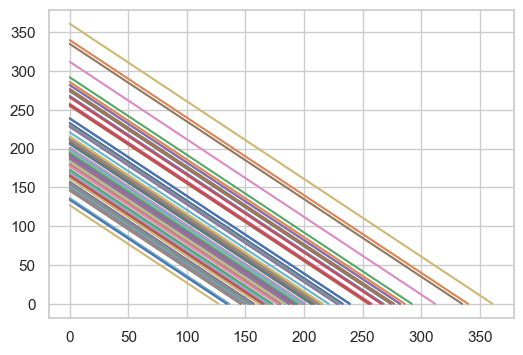

In [59]:
plt.figure(figsize=(6, 4))
one_engine = []

for i, r in FD001_df.iterrows():
  rul = r["RUL"]
  one_engine.append(rul)
  if rul == 0:
    plt.plot(one_engine)
    one_engine = []

plt.grid(True)
plt.show()

In [ ]:
FD001_df.groupby("unit")["RUL"].diff().value_counts()

RUL
-1.0    20531
Name: count, dtype: int64

In this dataset, all the lines appear linear because the Remaining Useful Life (RUL) decreases by exactly one unit at each cycle until it reaches zero — the failure point. This linear behavior happens because RUL is measured strictly by usage count and, in this case, the dataset simulates only one failure mode under fixed operational conditions (sea level, according to the documentation).

Therefore, each engine follows a perfectly uniform degradation pattern with no interruptions, maintenance events, or external influences. This makes the dataset suitable for baseline predictive models but less representative of real-world degradation scenarios, where multiple failure modes and operating conditions are present. We see more of this in **FD002** or **FD004**, for example.

In [62]:
# Writing the processed dataset
save_path= "../data/02_processed"
FD001_df.to_csv(save_path + "/FD001.csv", index= None)

# **PLOTS**

---

## Engine lifetime distribution

This plot shows the life cycle of a unit. The more hight the bar, mor cycles it has until the failure.

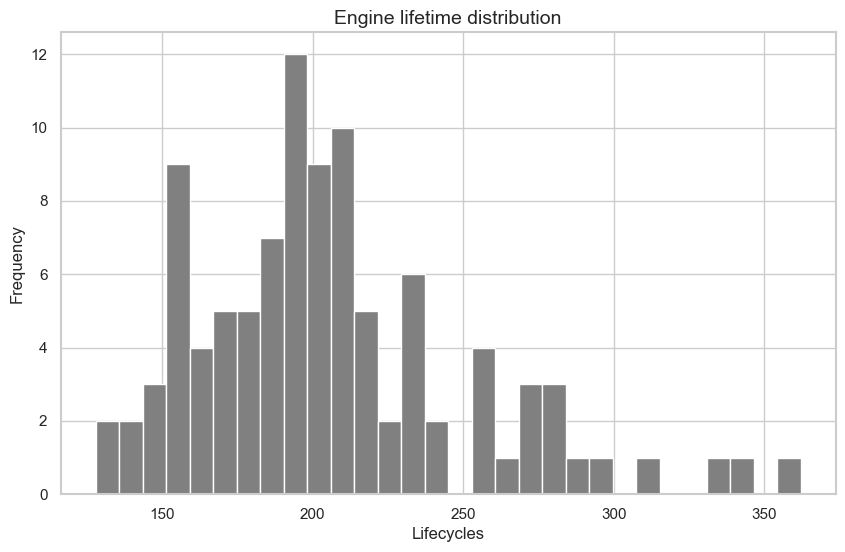

In [77]:
plt.figure(figsize=(10, 6))
FD001_df.groupby("unit")["cycle"].max().hist(bins=30, color="gray")
plt.title("Engine lifetime distribution")
plt.xlabel("Lifecycles")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Engine distribution across sensors

These boxplots show the distribution of the sensor measurements for each unit.

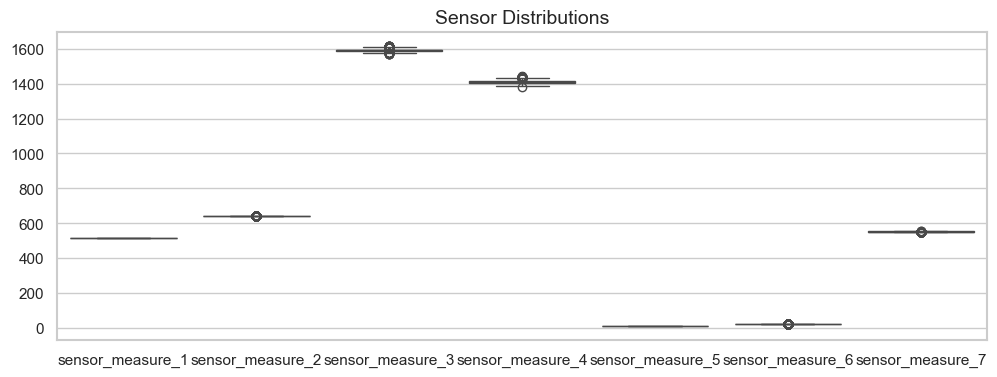

In [100]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=FD001_df[sensors[0:7]])
#plt.xticks(rotation=90)
plt.title("Sensor Distributions")
plt.show()


## Top 10 features correlation

Positive bars tell us which features are positively correlated with RUL. Negative bars tell us which features are negatively correlated with RUL.

In [113]:
corr_FD001= FD001_df.corr()
rul_corr=   corr_FD001['RUL'].sort_values(ascending= False)

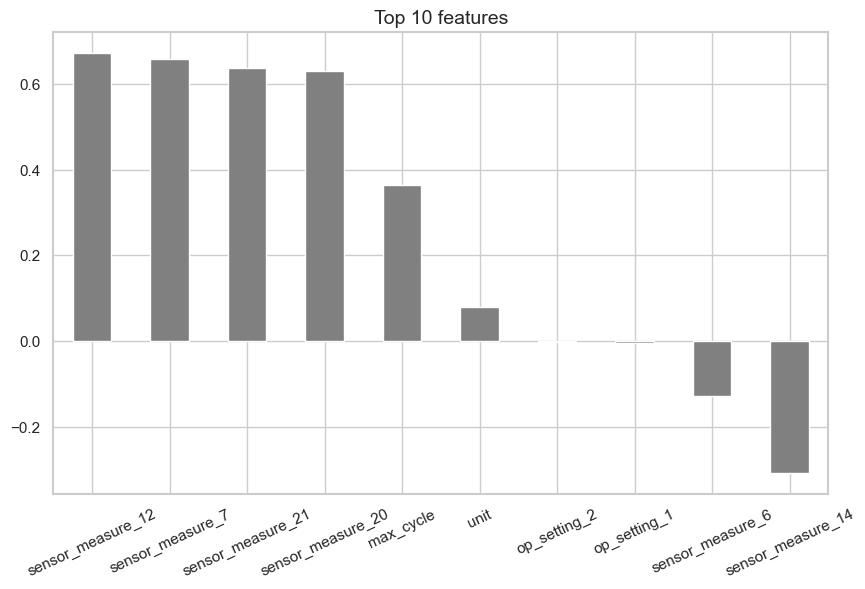

In [112]:
plt.figure(figsize=(10, 6))
top10_features= rul_corr[1:11]
top10_features.plot(kind= "bar", color= "gray")
plt.title("Top 10 features")
plt.xticks(rotation= 25)
plt.show()

## Correlation Matrix
Show us the correlation matrix for the dataset. Better visualise it with a heatmap.

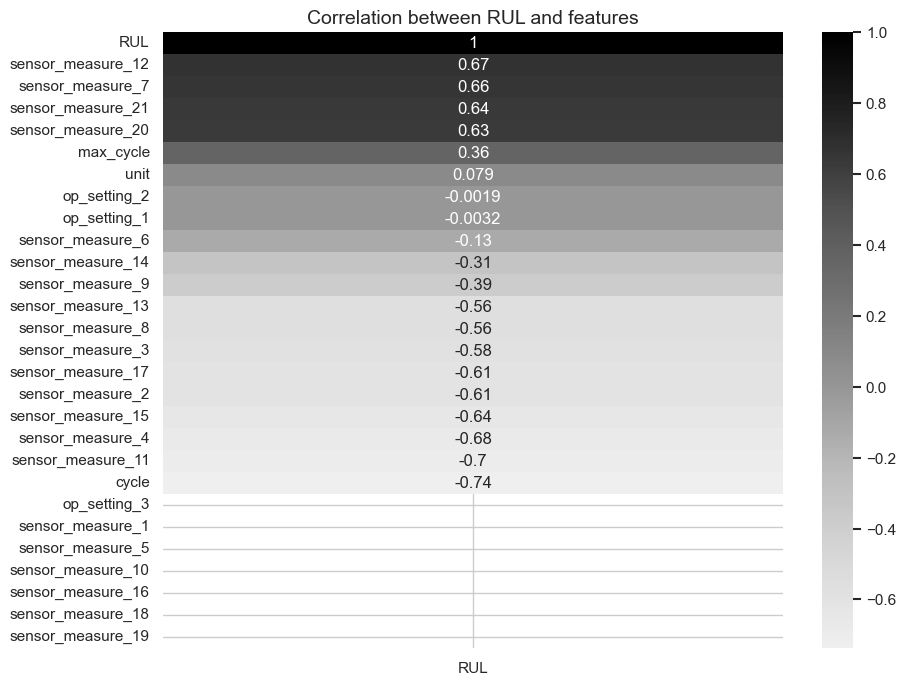

In [114]:
plt.figure(figsize=(10, 8))
sns.heatmap(rul_corr.to_frame(), annot=True, cmap="Greys", center=0)
plt.title("Correlation between RUL and features")
plt.show()